<a href="https://colab.research.google.com/github/Subashini03/X-ray-Classification/blob/main/ProjectProgrss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 X-RAY CLASSIFICATION USING CNN



# Import required dependancy modules


In [ ]:
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Import data repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/Covid19-X-Rays-master.zip"

# Load the image shapes and look at a sample X-Ray image
# Data Pre-processing

In [ ]:

INIT_LR = 1e-5    # This value is specific to what model is chosen: Inception
EPOCHS = 50
BS = 8

print("Loading images...")
imagePath = "/content/Covid19-X-Rays-master/all/train"
imagePaths = list(paths.list_images(imagePath))

data = []
labels = []

# read all X-Rays in the specified path, and resize them all to 256x256
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    data.append(image)
    labels.append(label)

#normalise pixel values to real numbers between 0.0 - 1.0
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding for a 3-class labeling
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)

print("... ... ", len(data), "images loaded in 3x classes:")
print(label_encoder.classes_)

Loading images...
... ...  200 images loaded in 3x classes:
['covid' 'normal' 'pneumonia_bac']


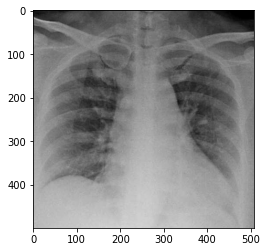

In [ ]:
import matplotlib.image as mpimg
filename = "/content/Covid19-X-Rays-master/all/train/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()

# Initialized training the model

In [ ]:
# split the data between train and validation.
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# add on a simple Augmentation.
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

#Use the InveptionV3 model with Transfer Learning of pre-trained "ImageNet"'s weights.
baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

#Add on a couple of custom CNN layers on top of the Inception V3 model.
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Compose the final model
model = Model(inputs=baseModel.input, outputs=headModel)

print("Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("Training the full stack model...")
H = model.fit_generator( trainAug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,
                         validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

87916544/87910968 [==============================] - 1s 0us/step
Compiling model...
Training the full stack model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 128s 6s/step - loss: 1.2444 - accuracy: 0.3496 - val_loss: 1.1960 - val_accuracy: 0.3000
Epoch 2/50
20/20 [==============================] - 117s 6s/step - loss: 1.0102 - accuracy: 0.5388 - val_loss: 1.0551 - val_accuracy: 0.3500
Epoch 3/50
20/20 [==============================] - 143s 7s/step - loss: 1.0121 - accuracy: 0.4961 - val_loss: 0.9515 - val_accuracy: 0.4250
Epoch 4/50
20/20 [==============================] - 121s 6s/step - loss: 0.9001 - accuracy: 0.5426 - val_loss: 0.8608 - val_accuracy: 0.4750
Epoch 5/50
20/20 [==============================] - 121s 6s/step - loss: 0.7617 - accuracy: 0.6970 - val_loss: 0.8361 - val_accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 120s 6s/step - loss: 0.7314 - accuracy: 0.6827 - val_loss: 0.8098 - val_accuracy: 0.5250
Epoch 7/50
20/20 [==============================] - 118s 6s/step - loss: 0.7226 - accuracy: 0.6828 - val_loss: 0.7465 - val_accuracy: 0.6750
Epoch 8/50
20

# Evaluate metrics and plot confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score

Evaluating the trained model ...
               precision    recall  f1-score   support

        covid       1.00      1.00      1.00        12
       normal       1.00      1.00      1.00        14
pneumonia_bac       1.00      1.00      1.00        14

     accuracy                           1.00        40
    macro avg       1.00      1.00      1.00        40
 weighted avg       1.00      1.00      1.00        40

[[12  0  0]
 [ 0 14  0]
 [ 0  0 14]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


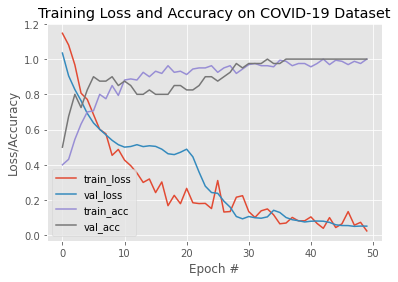

In [ ]:
print("Evaluating the trained model ...")
preds = model.predict(testX, batch_size=BS)

preds = np.argmax(preds, axis=1)

print(classification_report(testY.argmax(axis=1), preds, target_names=label_encoder.classes_))

# calculate a basic confusion matrix
cm = confusion_matrix(testY.argmax(axis=1), preds)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/Covid19-X-Rays-master/s-class-plot.png")

# Testing Samples

In [ ]:
imagePathTest = "/content/Covid19-X-Rays-master/all/test"
imagePathsTest = list(paths.list_images(imagePathTest))
print(len(imagePathsTest))

dataTest = []
labelsTest = []

# loop over the image paths
for imagePathTest in imagePathsTest:

    # extract the class label from the filename
	  labelTest = imagePathTest.split(os.path.sep)[-2]

	  # load the image, swap color channels, and resize it to be a fixed
	  # 256x256 pixels while ignoring aspect ratio
	  imageTest = cv2.imread(imagePathTest)
	  imageTest = cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB)
	  imageTest = cv2.resize(imageTest, (256, 256))

	  # update the data and labels lists, respectively
	  dataTest.append(imageTest)
	  labelsTest.append(labelTest)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
dataTest = np.array(dataTest) / 255.0
labelsTest = np.array(labelsTest)


# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelsTest)
labelsTest = to_categorical(integer_encoded)

print(labelsTest)

27
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
predTest = model.predict(dataTest, batch_size=BS)

print(predTest)

[[1.08991396e-02 9.63498712e-01 2.56022345e-02]
 [3.02429718e-04 9.97015476e-01 2.68202601e-03]
 [1.04788290e-02 9.73737657e-01 1.57834720e-02]
 [5.27591817e-03 6.90151751e-01 3.04572374e-01]
 [1.19242526e-03 9.97006834e-01 1.80077029e-03]
 [4.25500516e-03 9.91163731e-01 4.58122185e-03]
 [3.09846760e-03 9.05144513e-01 9.17569250e-02]
 [1.05788538e-04 9.95125830e-01 4.76836786e-03]
 [6.21771731e-04 9.97272313e-01 2.10587727e-03]
 [9.96293128e-01 1.00623653e-03 2.70068715e-03]
 [9.88887966e-01 9.15176875e-04 1.01969400e-02]
 [5.26533246e-01 1.19969964e-01 3.53496760e-01]
 [9.97971833e-01 7.10607055e-05 1.95710314e-03]
 [9.97845054e-01 4.81294846e-04 1.67368678e-03]
 [9.97702777e-01 9.24644934e-04 1.37257879e-03]
 [9.97848511e-01 1.42541854e-03 7.26028695e-04]
 [9.91288662e-01 2.54567107e-03 6.16567582e-03]
 [9.98773754e-01 2.66614461e-05 1.19960739e-03]
 [8.64485628e-04 7.52079487e-03 9.91614699e-01]
 [2.67270650e-03 7.13725947e-03 9.90190089e-01]
 [7.56394118e-02 3.53904404e-02 8.889700

# Predicted classess

In [ ]:
predClasses = predTest.argmax(axis=-1)
print(predClasses)

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2]


# Analyze Results for testing samples

In [ ]:
# make predictions on the testing set
print("Evaluating real test samples ...")

testX = dataTest
testY = labelsTest

predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=label_encoder.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Evaluating real test samples ...
               precision    recall  f1-score   support

        covid       1.00      1.00      1.00         9
       normal       1.00      1.00      1.00         9
pneumonia_bac       1.00      1.00      1.00         9

     accuracy                           1.00        27
    macro avg       1.00      1.00      1.00        27
 weighted avg       1.00      1.00      1.00        27

[[9 0 0]
 [0 9 0]
 [0 0 9]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


# Saving the model

In [ ]:
!mkdir -p saved_model
model.save('saved_model/inceptionV3')

INFO:tensorflow:Assets written to: saved_model/inceptionV3/assets


In [ ]:
# my_model directory
!ls saved_model

inceptionV3


In [ ]:
!ls saved_model/inceptionV3

assets	saved_model.pb	variables


# Import necessary packages

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import imutils
import matplotlib.pyplot as plt
import cv2

# Loading the previously trained and saved model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/inceptionV3')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Compute GradCAM heatmap

In [ ]:
with tf.GradientTape() as tape:
 last_conv_layer = model.get_layer('mixed10')
 iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
 model_out, last_conv_layer = iterate(testX)
 class_out = model_out[:, np.argmax(model_out[0])]
 grads = tape.gradient(class_out, last_conv_layer)
 pooled_grads = K.mean(grads, axis=(0, 1, 2))
 heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
# resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
# return the resulting heatmap to the calling function
        return heatmap

# View heatmap layered image

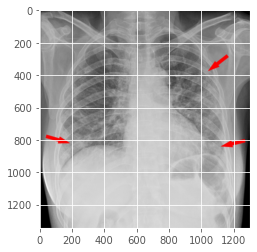

2 [[0.27609998 0.23534897 0.48855105]]


In [ ]:
import matplotlib.image as mpimg
filename = "/content/Covid19-X-Rays-master/all/test/covid/radiol.2020200490.fig3.jpeg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (256, 256))
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)
preds = new_model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)

# True Positive

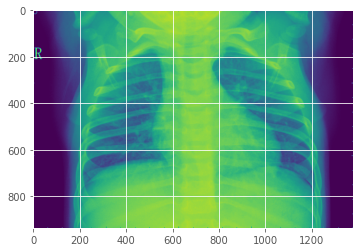

1 [[0.00309847 0.9051445  0.09175695]]


In [ ]:
import matplotlib.image as mpimg
filename = "/content/Covid19-X-Rays-master/all/test/normal/NORMAL2-IM-1406-0001.jpeg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (256, 256))
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)
preds = new_model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)

# Conflict

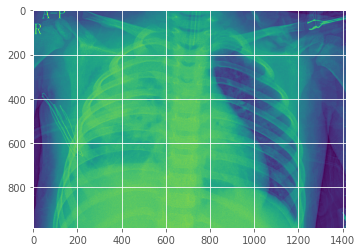

1 [[0.00309847 0.9051445  0.09175695]]


In [ ]:
filename = "/content/Covid19-X-Rays-master/all/test/pneumonia_bac/person1940_bacteria_4862.jpeg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()
preds = new_model.predict(dataXG)
j = np.argmax(preds[0])
print(j, preds)

# True positive

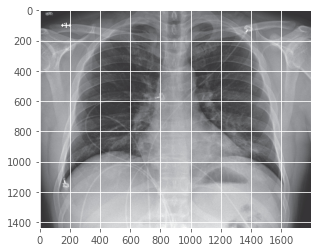

0 [[0.9917868  0.00206979 0.00614346]]


In [ ]:
import matplotlib.image as mpimg
filename = "/content/Covid19-X-Rays-master/all/test/covid/nejmoa2001191_f4.jpeg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (256, 256))
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)
preds = new_model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)

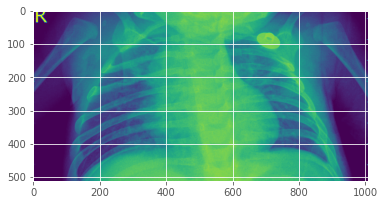

2 [[0.02264587 0.24256456 0.73478955]]


In [ ]:
import matplotlib.image as mpimg
filename = "/content/Covid19-X-Rays-master/all/test/pneumonia_bac/person1943_bacteria_4868.jpeg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (256, 256))
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)
preds = new_model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)

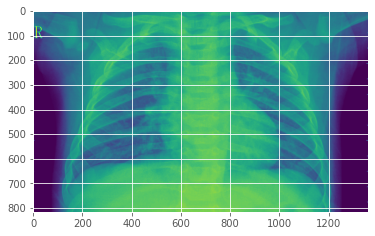

2 [[0.03377661 0.04171726 0.9245061 ]]


In [ ]:
filename = "/content/Covid19-X-Rays-master/all/test/pneumonia_bac/person1941_bacteria_4863.jpeg"
orignal = mpimg.imread(filename)
plt.imshow(orignal)
plt.show()
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (256, 256))
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)
preds = new_model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)